In [5]:
from vk_api import *
import networkx
from networkx import *
DEEP = 0
FRIENDS_LIMIT = 30

In [6]:
#Авторизация в ВК
login, password = '79870984464', 'newparol'
vk_session = vk_api.VkApi(login, password)
try:
    vk_session.auth(token_only=True)
except vk_api.AuthError as error_msg:
    print(error_msg)
vk = vk_session.get_api()

In [7]:
#Считывание первичных пользователей
file = open('id_group.txt')
data_id = file.read().split('\n')
data_id = list(map(int,data_id))
file.close()

In [8]:
#init графа, создание лога ошибок
G = nx.Graph()
ER_LOG = open('ERROR_LOG.txt','w')
#пользователи представлены в виде словаря: ключ - пользователь. значения - его друзья
users = {}
#первый цикл добавит друзей в 1-ом приближении, тут нет ограничения на кол-во друзей
for user in data_id:
    G.add_node(user)
    try:
        users[user] = vk.friends.get(user_id=user,count=20)['items']
        for friend in users[user]:
                G.add_node(friend)
                G.add_edge(user,friend)
    except vk_api.ApiError as error_msg:
        ER_LOG.write('user_id:' + str(user) + str(error_msg) + '\n')
k = 1
#Второй цикл будет добавлять друзей друзей и т.д. до нужной глубины
#Использую while т.к. потом добавлю функцию, которая будет проверять, может уже построились все необходимые связи
#и дальше искать друзей не нужно
while k <= DEEP:
    '''Пользователи, которые уже добавлены кому-то в друзья, но для них самих список друзей ещё не получен
    ищутся как разность между множеством ключей и множеством значений. Это сразу помогает избавится и от повторений
    и от зацикливания и от повторной обработки людей, которые уже добавлены'''
    new_users = set([item for sublist in users.values() for item in sublist]).difference(users.keys())
    for user in new_users:
        G.add_node(user)
        try:
            users[user] = vk.friends.get(user_id=user,count=FRIENDS_LIMIT)['items']
            for friend in users[user]:
                G.add_node(friend)
                G.add_edge(user,friend)
        except vk_api.ApiError as error_msg:
            ER_LOG.write('user_id:' + str(user) + str(error_msg) + '\n')
    k += 1
ER_LOG.close()

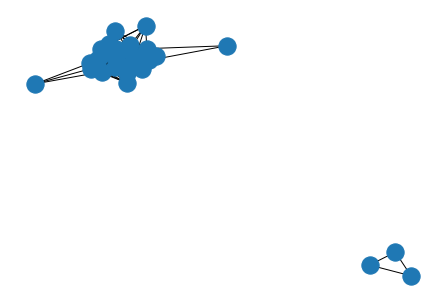

In [19]:
#nx.shortest_path(G, 0, 3)
'''Дальше будет обработка графа с помощью функции кратчайшего пути, все лишние элементы будут выкинуты'''
shortest_path=[]
PATH_ERROR_LOG=open('PATH_ERROR_LOG.txt','w')
for i in data_id:
    for j in data_id[data_id.index(i) + 1:]:
        try:
            shortest_path.append(nx.shortest_path(G,i,j))
        except nx.NetworkXNoPath as error_msg:
            PATH_ERROR_LOG.write('node1:' + str(i) + 'node2:' + str(j) + str(error_msg))
result_graph = nx.Graph()
for path in shortest_path:
    for node1 in path:
        result_graph.add_node(node1)
        for node2 in path[path.index(node1)+1:]:
            result_graph.add_node(node2)
            result_graph.add_edge(node1,node2)
len(G.nodes())
len(result_graph.nodes())
nx.draw(result_graph)